In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

(ds_train_full, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

ds_train = ds_train_full.take(int(0.8 * len(ds_train_full)))
ds_val = ds_train_full.skip(int(0.8 * len(ds_train_full)))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.S6UK61_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.S6UK61_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [2]:
def preprocess(image, label):
    image = tf.image.resize(image, (71, 71))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# def augment(image, label):
#     image, label = preprocess(image, label)
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_brightness(image, max_delta=0.1)
#     image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
#     return image, label

In [3]:
batch_size = 32

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache().shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [4]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(71, 71, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

83683744/83683744 [==============================] - 3s 0us/step


In [5]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_rps1.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3)
]
history = model.fit(ds_train, epochs=30, validation_data=ds_val, callbacks = callbacks)

Epoch 1/30
63/63 [==============================] - 79s 1s/step - loss: 0.8052 - accuracy: 0.6434 - val_loss: 0.3628 - val_accuracy: 0.9226
Epoch 2/30
63/63 [==============================] - 71s 1s/step - loss: 0.3647 - accuracy: 0.8735 - val_loss: 0.1796 - val_accuracy: 0.9782
Epoch 3/30
63/63 [==============================] - 69s 1s/step - loss: 0.2406 - accuracy: 0.9236 - val_loss: 0.1163 - val_accuracy: 0.9821
Epoch 4/30
63/63 [==============================] - 69s 1s/step - loss: 0.1860 - accuracy: 0.9395 - val_loss: 0.0754 - val_accuracy: 0.9940
Epoch 5/30
63/63 [==============================] - 68s 1s/step - loss: 0.1464 - accuracy: 0.9479 - val_loss: 0.0575 - val_accuracy: 0.9940
Epoch 6/30
63/63 [==============================] - 65s 1s/step - loss: 0.1233 - accuracy: 0.9583 - val_loss: 0.0416 - val_accuracy: 0.9960
Epoch 7/30
63/63 [==============================] - 85s 1s/step - loss: 0.1016 - accuracy: 0.9663 - val_loss: 0.0337 - val_accuracy: 0.9940
Epoch 8/30
63/63 [==

In [6]:
import keras
test_model = keras.models.load_model('convnet_from_scratch_rps1.keras')
test_loss, test_acc = test_model.evaluate(ds_test)

12/12 [==============================] - 14s 1s/step - loss: 0.4048 - accuracy: 0.8065


<Figure size 640x480 with 0 Axes>

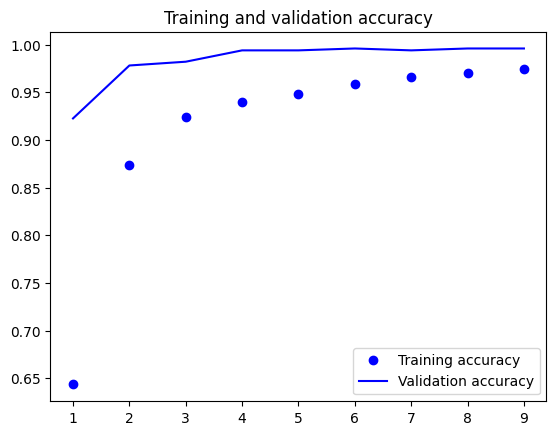

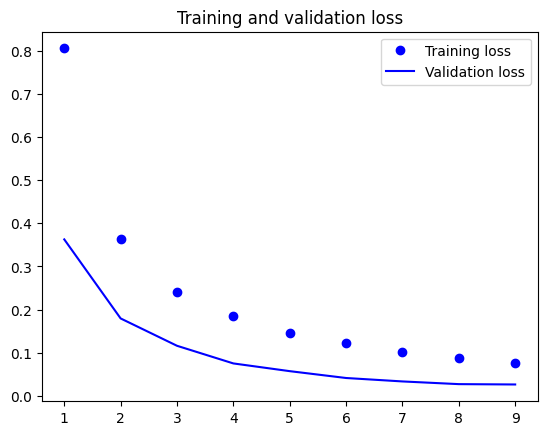

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.figure()